<a id='top'></a>

# What can an Airbnb host do to maximize occupancy?

#### A recent extended stay at an Airbnb rental with a newbie host prompted me to wonder, What can a host do to increase occupancy at his or her property? I set out to see if data science might provide the answer – perhaps to the benefit of hapless hosts.

#### Using data from Airbnb, I sought to predict properties with 75% occupancy for 60 days in the future (the target). For features I chose aspects of rentals that hosts have some control over.

#### Turns out there's a lot that hosts can do that is predictive of lower vacancy rates. Read on to find out.

- [Step 1](#Step_1) Preprocessing: After reviewing the 105 variables from Airbnb, I chose 15 to format and edit for creating features. I assessed and addressed missing data (delete cases or recode as zero), cleaned string data to create numeric data, and tallied a string variable to create a numeric variable.
- [Step 2](#Step_2) Outliers. I created boxplots of raw variables (which will be used to create features) to review for outliers. There were many outliers, which likely reflect atypical properties or data entry errors. Therefore, I removed outliers -- cases more than three standard deviations from the mean -- so as to construct a better model.
- [Step 3](#Step_3) Feature engineering. Using price, number of guests a rental accommodates, and the numbers of property characteristics (bedrooms, bathrooms, beds), I created features that are standardized or summed: total and incremental costs for a full house; price per person; and bathrooms, bedrooms and beds per person. Then to finish the preprocessing, I coded the target, dropped the raw data variables used for feature engineering, and scaled all features.
- [Step 4](#Step_4) Feature selection. Grouping features into three sets relating to costs, facilities/amenities, and reviews, I created correlograms and correlation matrices to discern if features within these sets add useful, additional information for the model, or whether features can be combined and/or deleted. Visualizations and correlation matrices did not reveal closely related features, so all were retained for model building.
- [Step 5](#Step_5)  Model building and feature importance ranking. I compared and plotted results from seven machine learning algorithms. Four models had accuracy scores of .83. I identified the most important features for predicting high occupancy rates at Airbnb properties. See the top 10 list, and pay heed if you're an Airbnb host. 

In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
#import datetime as dt
#from datetime import datetime
#from datetime import timedelta 
#import plotly.graph_objects as go

Back to [top](#top) 

<a id='Step_1'></a>

#### Step 1: Preprocessing
I assessed and addressed missing data (delete cases or recode as zero), cleaned string data to create numeric data, and tallied a string variable to create a numeric variable.

In [2]:
file_loc = "C:/Users/rmbrm/Documents/airbnb/listings.csv"
df = pd.read_csv(file_loc, index_col=None, na_values=['NA'], 
    usecols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'cleaning_fee', 'guests_included',
               'extra_people', 'availability_60', 'review_scores_accuracy', 'review_scores_cleanliness',
               'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
               'amenities'])
df.shape

(20677, 16)

In [3]:
missing = df.isnull().sum()
missing[missing!=0]

bathrooms                         6
bedrooms                          8
beds                              8
cleaning_fee                   3721
review_scores_accuracy         2827
review_scores_cleanliness      2825
review_scores_checkin          2837
review_scores_communication    2830
review_scores_location         2835
review_scores_value            2835
dtype: int64

In [4]:
# Recode cleaning fee cases that are missing data as zero; drop missing cases for other features; 
# make three cost features numeric by removing string characters; and engineer a feature (number of amenities),
# so that it can be included in the raw data to be reviewed for outliers

df['cleaning_fee'].fillna(0, inplace=True)
df.dropna(inplace=True)

cols = ['price', 'cleaning_fee', 'extra_people']
df[cols] = df[cols].replace({'\$': '', ',': ''}, regex=True)
df[cols] = df[cols].astype(float)

df['amen_count']=(df['amenities'].str.count(',') + 1)

df.shape

(17821, 17)

Back to [top](#top) 

<a id='Step_2'></a>

#### Step 2: Outliers
I created boxplots of raw variables (which will be used to create features) to review for outliers. There are many outliers, which likely  reflect atypical properties or data entry errors. Therefore, I'll remove outliers -- cases more than three standard deviations from the mean -- so as to construct a better model.

Text(0.5, 1.0, 'Outliers for Number of Amenities Features')

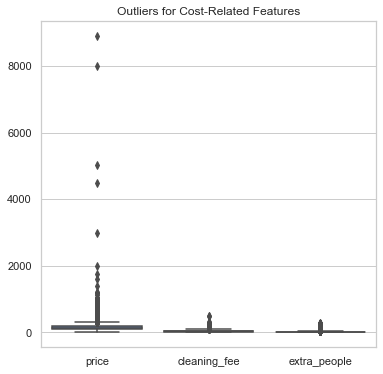

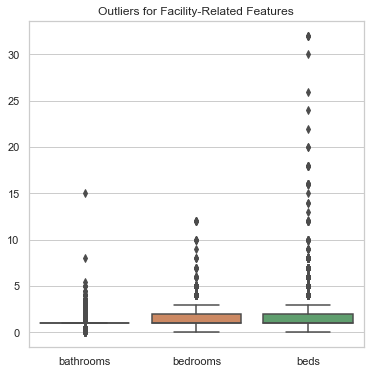

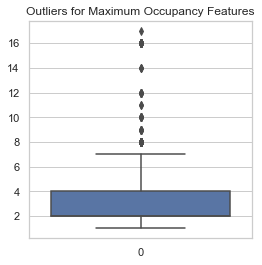

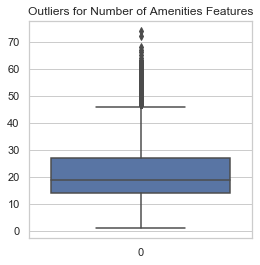

In [5]:
costs = ['price', 'cleaning_fee', 'extra_people']
rooms = ['bathrooms', 'bedrooms', 'beds']
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.title('Outliers for Cost-Related Features')
ax = sns.boxplot(data=df[costs])
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.title('Outliers for Facility-Related Features')
ax = sns.boxplot(data=df[rooms])
sns.set(style="whitegrid")
plt.figure(figsize=(4, 4))
plt.title('Outliers for Maximum Occupancy Features')
ax = sns.boxplot(data=df['accommodates'])
sns.set(style="whitegrid")
plt.figure(figsize=(4, 4))
ax = sns.boxplot(data=df['amen_count'])
plt.title('Outliers for Number of Amenities Features')

In [6]:
# Delete outliers

features = ["accommodates", "bathrooms", "bedrooms", "beds", "price", "cleaning_fee", "guests_included", "amen_count"]
cols = df.columns.intersection(features)
for col in cols:
    df = df[np.abs(df[col]-df[col].mean())<=(3*df[col].std())]

df.shape

(15762, 17)

Back to [top](#top) 

<a id='Step_3'></a>

#### Step 3: Feature engineering

Using price, number of guests a rental accommodates, and the numbers of property characteristics (bedrooms, bathrooms, beds), I created features that are standardized or summed: total and incremental costs for a full house; price per person; and bathrooms, bedrooms and beds per person. Then to finish the preprocessing, I coded the target, dropped the raw data variables used for feature engineering, and scaled all features.

In [7]:
# Create standardized or summed features

df['extra_for_full_house'] = ((df['accommodates'] - df['guests_included'])* df['extra_people'])
df['total__for_full_house'] = df['extra_for_full_house']+ df['price']
df['price_per_person'] = df['price']/df['guests_included']
df['bathrooms_per_person'] = df['bathrooms']/df['guests_included']
df['bedrooms_per_person'] = df['bedrooms']/df['guests_included']
df['beds_per_person'] = df['beds']/df['guests_included']

# Code target

def recode(days):
    if days < 15:
        return 1
    else:
        return 0
df['target'] = df.apply(lambda x: recode(x['availability_60']), axis=1)

# Remove raw variables

df.drop(["accommodates", "bathrooms", "bedrooms", "beds", "amenities", "price", "guests_included",
         "extra_people", "availability_60"], axis=1, inplace=True)

# Scale all features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df.loc[:, 'cleaning_fee': 'beds_per_person'] = scaler.fit_transform(df.loc[:, 'cleaning_fee': 'beds_per_person'])

Back to [top](#top) 

<a id='Step_4'></a>

#### Step 4: Feature selection

Grouping features into three sets relating to costs, facilities/amenities, and reviews, I created correlograms and correlation matrices to discern if features within these sets add useful, additional information for the model, or whether features can be combined and/or deleted. Visualizations and correlation matrices did not reveal closely related features, so all were retained for model building.

Text(0.5, 1, 'Cost-Related Features')

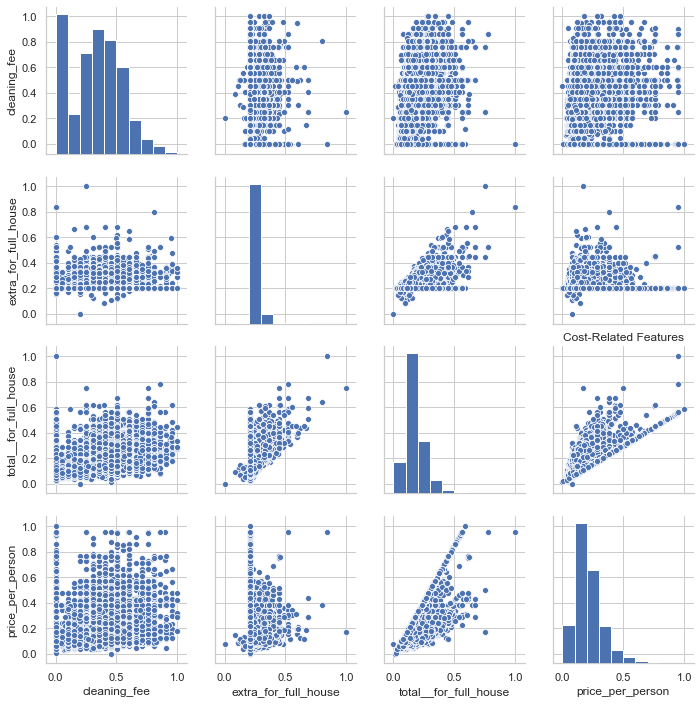

In [8]:
sns.pairplot(df[['cleaning_fee', 'extra_for_full_house', 'total__for_full_house', 'price_per_person']])
plt.title('Cost-Related Features')

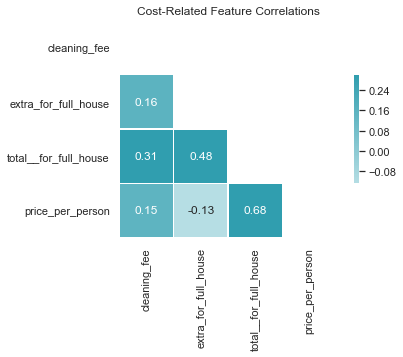

In [9]:
corr = df[['cleaning_fee', 'extra_for_full_house', 'total__for_full_house', 'price_per_person']].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Cost-Related Feature Correlations')
plt.show()
plt.show()

Text(0.5, 1, 'Facility/Amenity-Related Features')

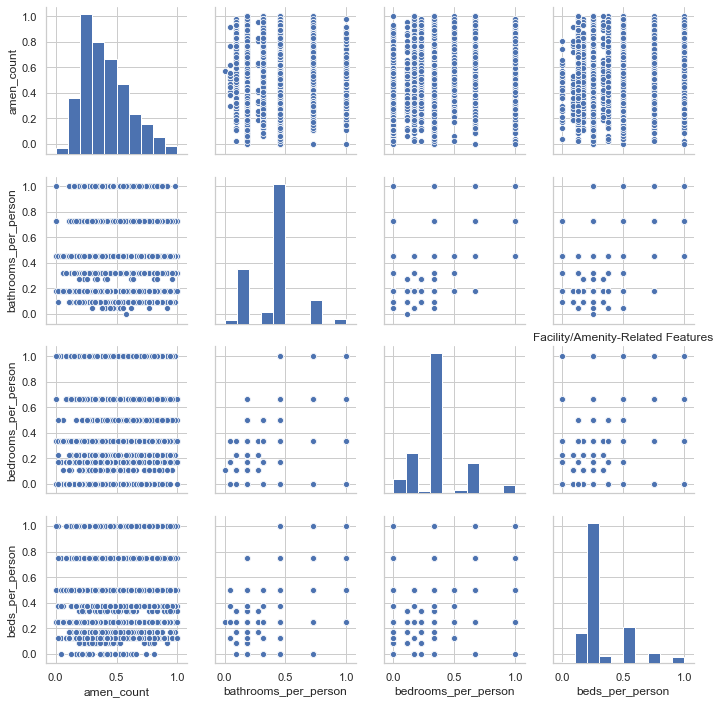

In [10]:
sns.pairplot(df[['amen_count', 'bathrooms_per_person', 'bedrooms_per_person', 'beds_per_person']])
plt.title('Facility/Amenity-Related Features')

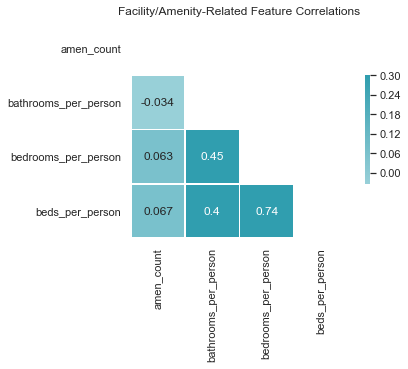

In [11]:
corr = df[['amen_count', 'bathrooms_per_person', 'bedrooms_per_person', 'beds_per_person']].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Facility/Amenity-Related Feature Correlations')
plt.show()
plt.show()

Text(0.5, 1, 'Reviews Features')

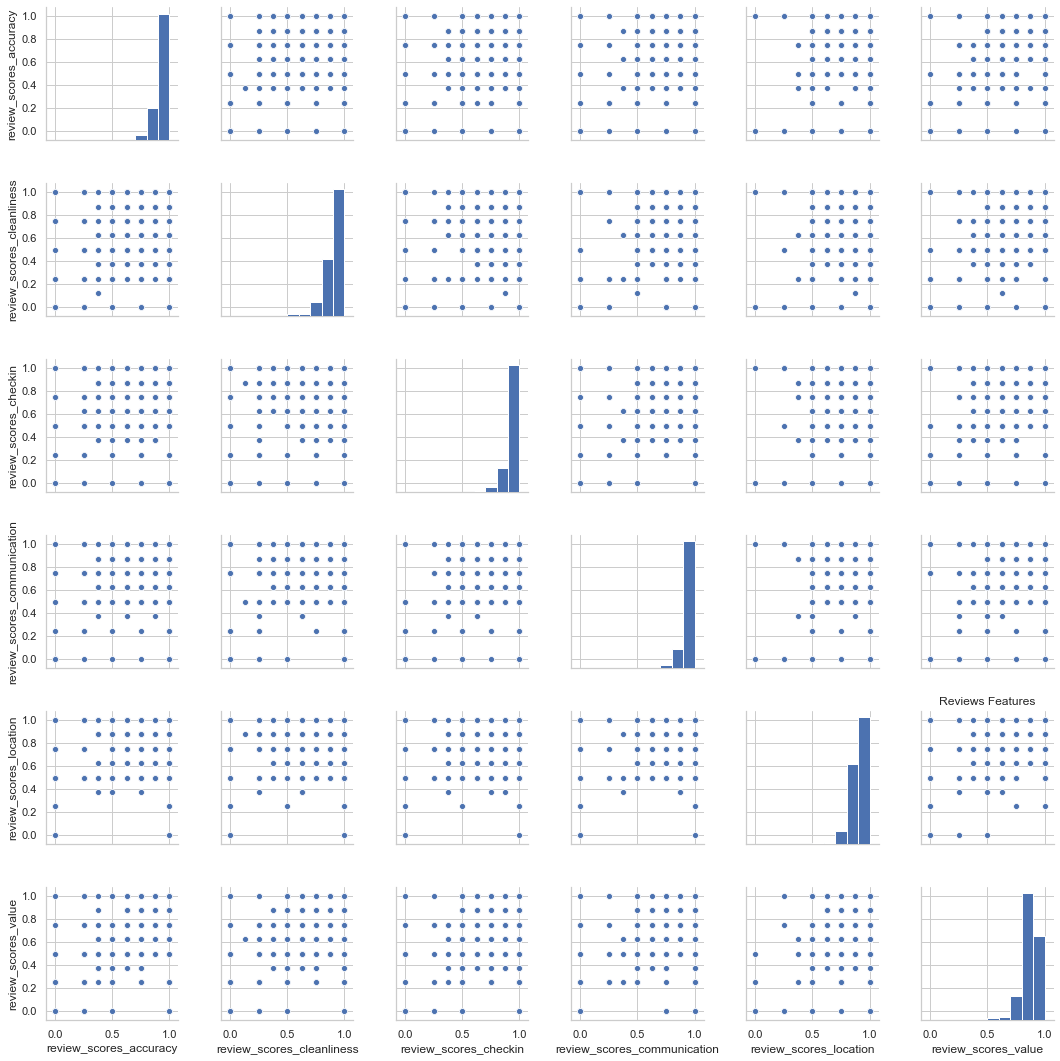

In [12]:
sns.pairplot(df[["review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", 
                 "review_scores_location", "review_scores_value"]])
plt.title('Reviews Features')

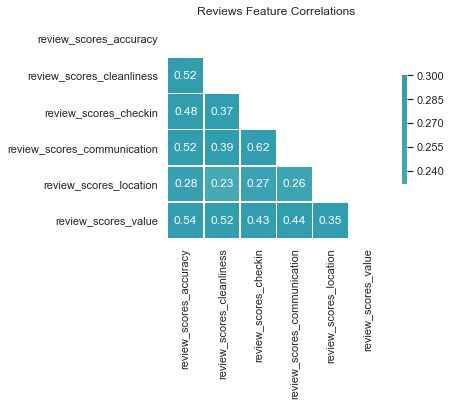

In [13]:
corr = df[["review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication",
           "review_scores_location", "review_scores_value"]].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Reviews Feature Correlations')
plt.show()
plt.show()

Back to [top](#top) 

<a id='Step_5'></a>

#### Step 5: Model building and feature importance ranking.

I compared and plotted results from seven machine learning algorithms. Four models had accuracy scores of .83. I identified the most important features for predicting high occupancy rates at Airbnb properties. See the top 10 list, and pay heed if you're an Airbnb host. 
; )


In [14]:
features = df.drop(df.columns[14], axis=1)
target = df['target']
X = features.values
y = target.values
print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (15762, 14) y.shape: (15762,)


LR: 0.831494 (0.023896)
LDA: 0.830796 (0.022803)
KNN: 0.814427 (0.020485)
NB: 0.784422 (0.024341)
SVC: 0.831557 (0.024509)
RFC: 0.799455 (0.021345)
GBC: 0.831113 (0.023317)


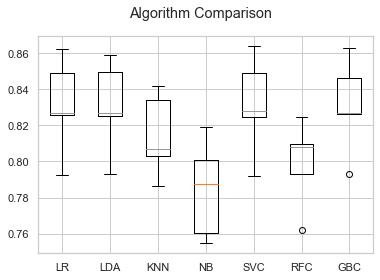

In [16]:
# Compare and plot accuracy of seven machine learning algorithms

from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', LinearSVC()))
models.append(('RFC', RandomForestClassifier()))
models.append(('GBC', GradientBoostingClassifier()))

# evaluate each model
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=42)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplots of accuracy scores and range
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [54]:
features = df.drop(df.columns[14], axis=1)
target = df['target']

In [55]:
X = features.values
y = target.values

In [56]:
print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (15762, 14) y.shape: (15762,)


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 42)
forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score( X_test, y_test)))

Accuracy on training set: 0.998
Accuracy on test set: 0.839


Feature Ranking:
1. feature 7 (0.175647)
2. feature 9 (0.169295)
3. feature 10 (0.166005)
4. feature 0 (0.135503)
5. feature 8 (0.053749)
6. feature 13 (0.043443)
7. feature 11 (0.041741)
8. feature 12 (0.041076)
9. feature 2 (0.039842)
10. feature 6 (0.031480)
11. feature 5 (0.030617)
12. feature 3 (0.026160)
13. feature 1 (0.023346)
14. feature 4 (0.022096)


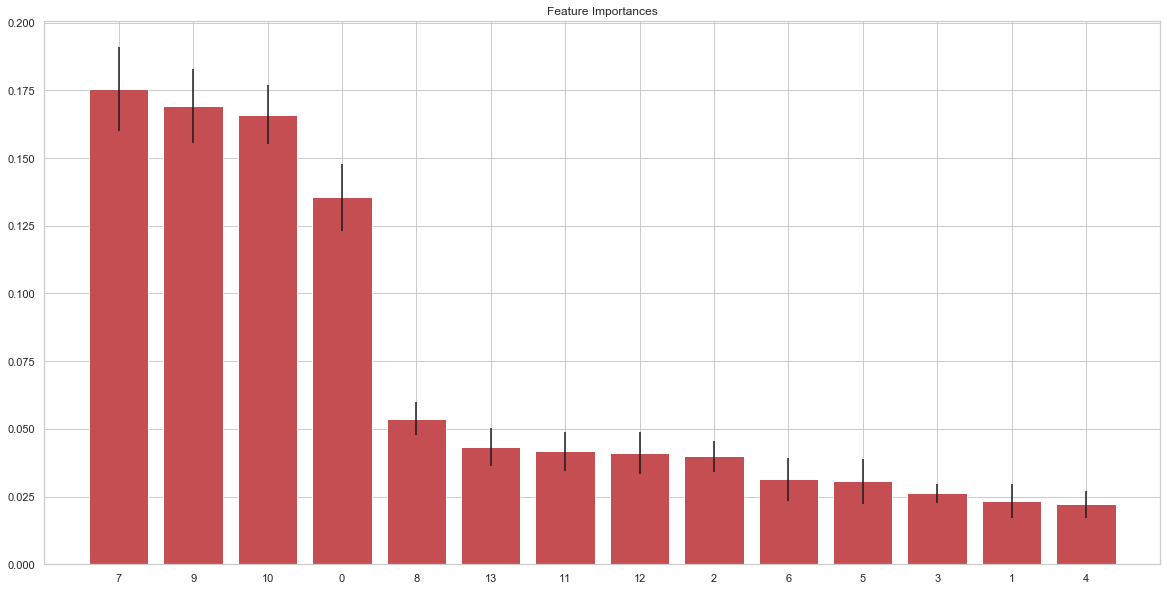

In [18]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature Ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

| Feature                                        | Proportion of effect on target     |
|------------------------------------------------|------------------------------------|
|  Number of amenities                           | 0.18                               |
|------------------------------------------------|------------------------------------|
|  Total cost for a full house                   | 0.17                               |
|------------------------------------------------|------------------------------------|
|  Price per person                              | 0.17                               |
|------------------------------------------------|------------------------------------|
|  Cleaning fee                                  | 0.14                               |
|------------------------------------------------|------------------------------------|
|  Extra cost for a full house                   | 0.05                               |
|------------------------------------------------|------------------------------------|
|  Beds per person                               | 0.04                               |
|------------------------------------------------|------------------------------------|
|  Bathrooms per person                          | 0.04                               |
|------------------------------------------------|------------------------------------|
|  Bedrooms per person                           | 0.04                               |
|------------------------------------------------|------------------------------------|
|  Reviews for cleanliness                       | 0.04                               |
|------------------------------------------------|------------------------------------|
|  Reviews score for value                       | 0.03                               |
|------------------------------------------------|------------------------------------|

